In [1]:
# Read simulator images from udacity training set
import csv
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os
%matplotlib inline

lines = []
with open('data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)

# Create training set
images = []
measurements = []
images_mod = []

for line in lines:
    # csv format: center,left,right,steering,throttle,brake,speed
    # Read in images; convert to RGB using cv2
    # Correct the left and right images with a correction of +- 0.2
    source_path_center = line[0]
    source_path_left = line[1]
    source_path_right = line[2]

    center_path = 'data/' + source_path_center # Updated pathnames
    left_path = 'data/' + source_path_left
    right_path = 'data/' + source_path_right

    center_image = cv2.imread(center_path) # Read in images
    left_image = cv2.imread(left_path)
    right_image = cv2.imread(right_path)

    if center_image is not None: # Create dataset using images/steering angles from each camera
        img = cv2.cvtColor(center_image, cv2.COLOR_BGR2RGB)
        
        img1 = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY )
        #img1 = img1[..., np.newaxis]
        img1 = img1[50:300,:]
        images_mod.append(img1)
        
        images.append(img)
        measurements.append(float(line[3]))
    if left_image is not None:
        img = cv2.cvtColor(left_image, cv2.COLOR_BGR2RGB)
        
        img1 = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY )
        #img1 = img1[..., np.newaxis]
        img1 = img1[50:300,:]
        images_mod.append(img1)
        
        images.append(img)
        measurements.append(float(line[3]) + 0.2)
    if right_image is not None:
        img = cv2.cvtColor(right_image, cv2.COLOR_BGR2RGB)
        
        img1 = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY )
        #img1 = img1[..., np.newaxis]
        img1 = img1[50:300,:]
        images_mod.append(img1)
        
        images.append(img)
        measurements.append(float(line[3]) - 0.2)


# Add some more images by flipping using numpy
# Angle for flipped image is the opposite direction (*-1)
r = len(images)
for i in range(2000):
    idx=np.random.randint(r)
    images.append(np.fliplr(images[idx]))
    measurements.append(measurements[idx] * -1)
     
X_train = np.array(images)
y_train = np.array(measurements)

print ("Dataset size: ", X_train.shape)
print ("Dataset shape: ", X_train[0].shape)

Dataset size:  (12595, 160, 320, 3)
Dataset shape:  (160, 320, 3)


In [2]:
# plot some of the random images
fig=plt.figure(figsize=(16,16))
for i in range(24):
    ax = fig.add_subplot(6,4,i+1)
    idx = np.random.randint(len(images_mod));
    plt.imshow(images_mod[idx], cmap='gray');
    plt.axis('off')
    

/home/rakeshr/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['monospace'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


/home/rakeshr/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['monospace'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


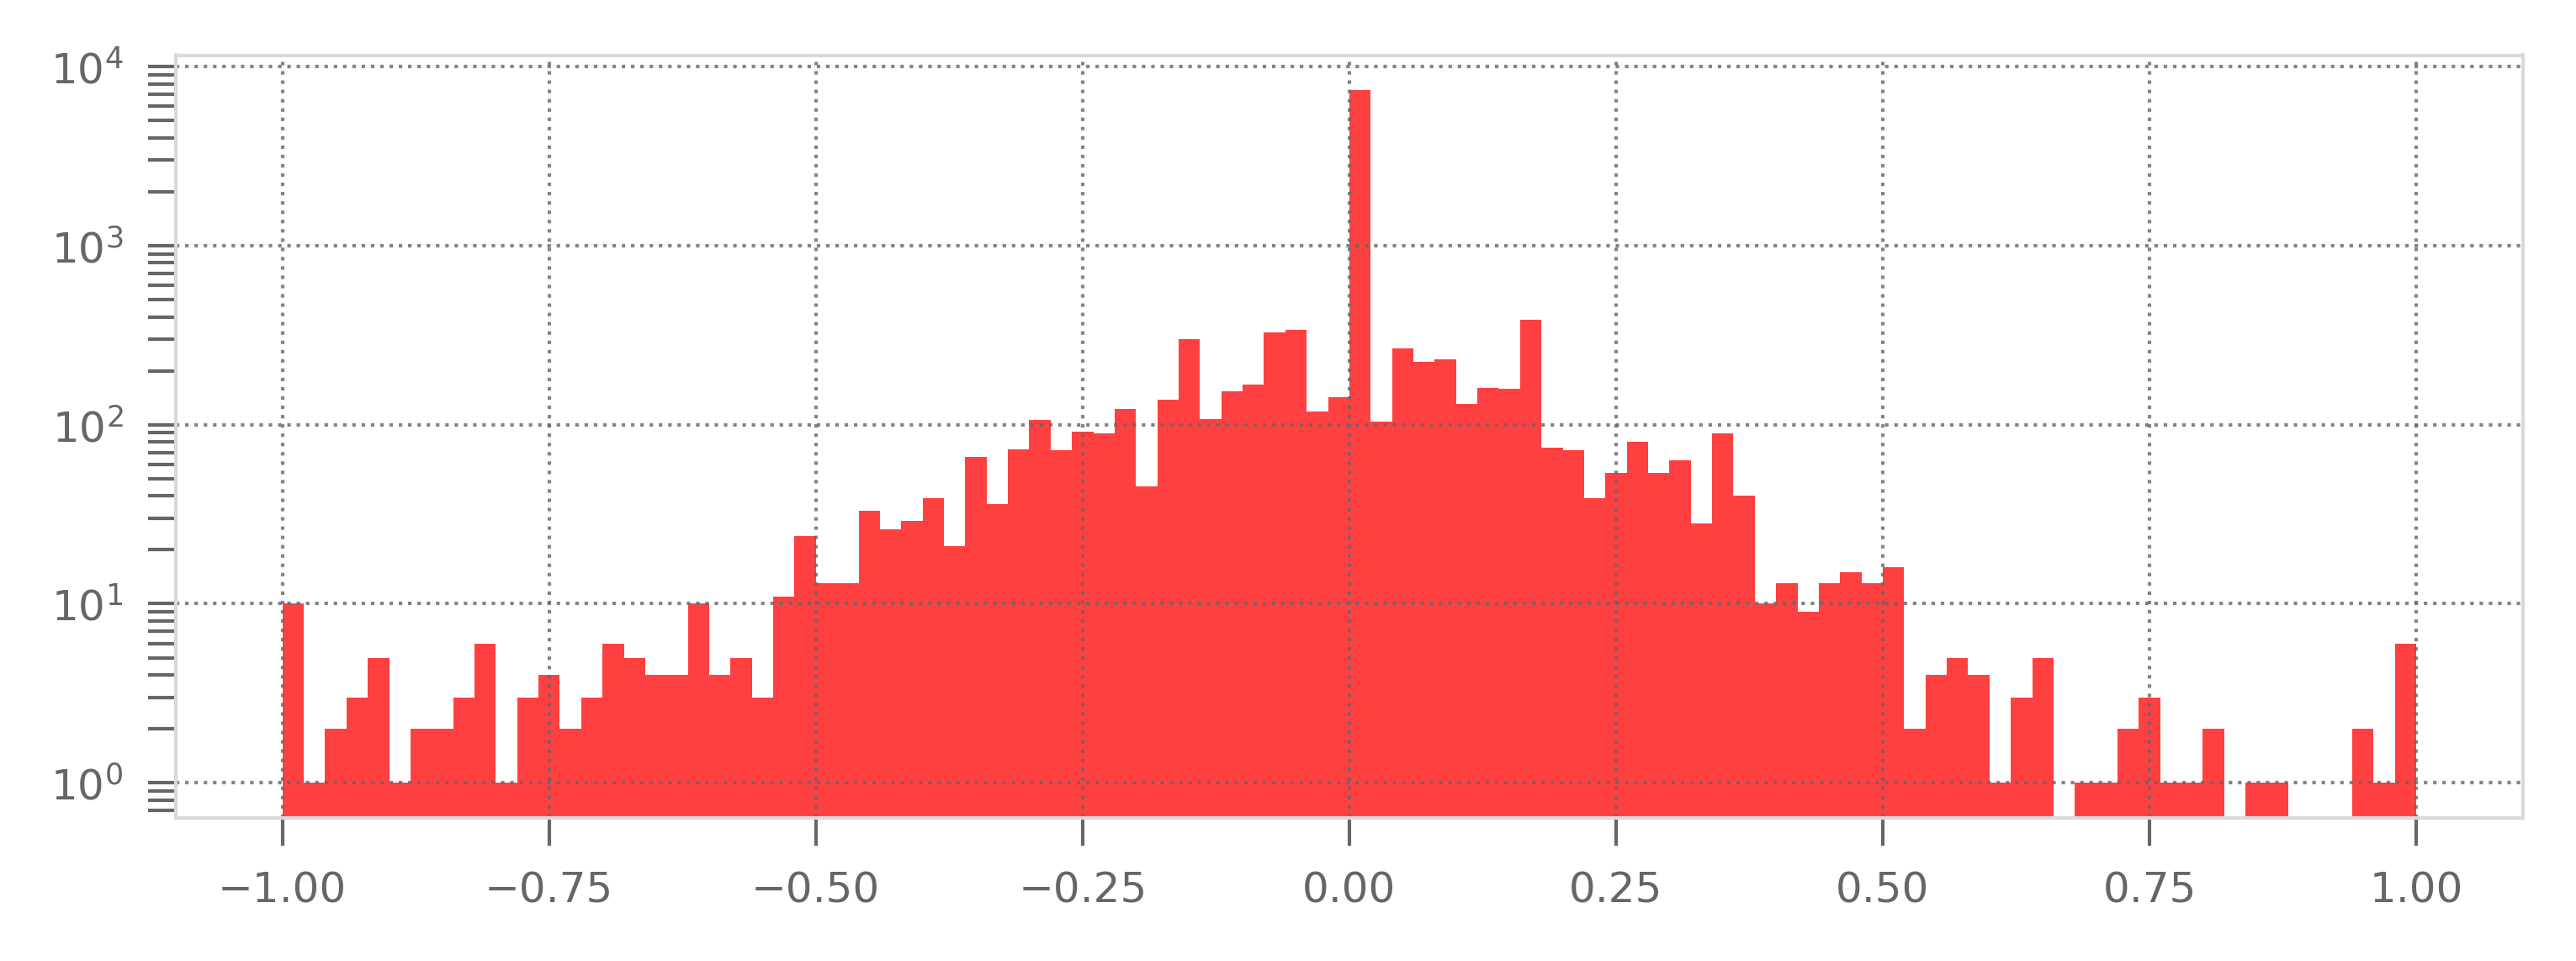

In [3]:
# Check training set angles 
plt.figure(figsize=(6,2))
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.hist(y_train, bins=100, facecolor='r', alpha=0.75, log='log');

/home/rakeshr/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['monospace'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


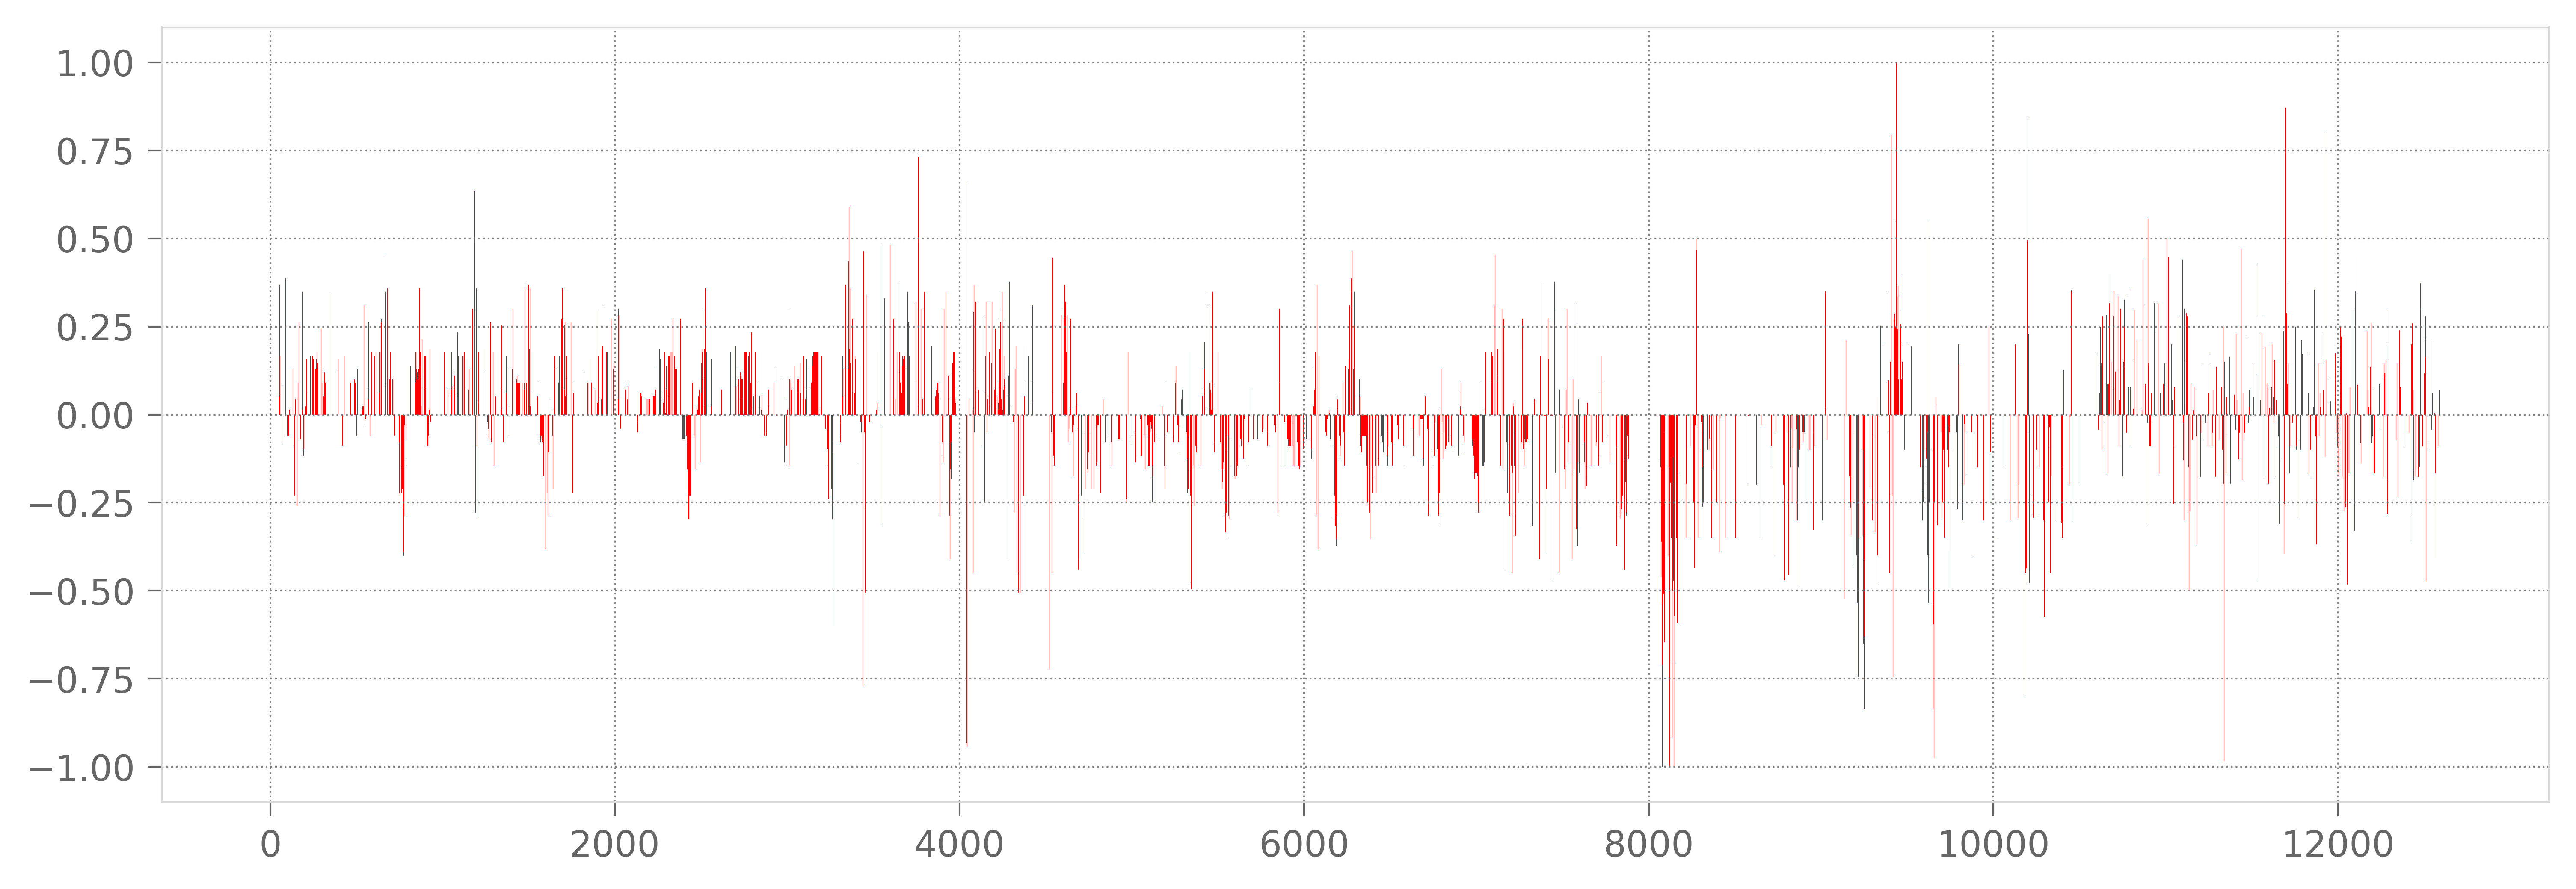

In [4]:
# Check training set angles 
plt.figure(figsize=(12, 4))
plt.bar(range(len(y_train)), y_train, color='r');
#plt.xlim(0,8000)

In [5]:
# Model based on https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/
# Using keras
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers import Dropout, Dense, Lambda, Cropping2D, Activation, Flatten

model = Sequential()

# pre process as described in lecture
# 1. Normalize input data
model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(160,320,3))) 

# 2. Crop 60 pixels off the top and 10 pixels off the bottom of images
model.add(Cropping2D(cropping=((60,10),(0,0)))) 

Using TensorFlow backend.


In [6]:
model.add(Conv2D(filters=8, kernel_size=5, strides=(2, 2), activation='relu'))
model.add(BatchNormalization(axis=1))
#model.add(Dropout(0.2))
model.add(Conv2D(filters=16, kernel_size=5, strides=(2, 2), activation='relu'))
#model.add(BatchNormalization(axis=1))
#model.add(Dropout(0.2))
model.add(Conv2D(filters=24, kernel_size=5, strides=(2, 2), activation='relu'))
#model.add(Dropout(0.35))
model.add(Conv2D(filters=32, kernel_size=3, strides=(1, 1), activation='relu'))
#model.add(Dropout(0.3))
model.add(Conv2D(filters=64, kernel_size=3, strides=(1, 1), activation='relu'))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# train model
model.fit(X_train, y_train, validation_split=0.25, shuffle=True, epochs=10)
model.save('model.h5')

Train on 9446 samples, validate on 3149 samples
Epoch 1/10
9446/9446 [==============================] - 20s - loss: 0.0151 - acc: 0.5647 - val_loss: 0.0181 - val_acc: 0.6215

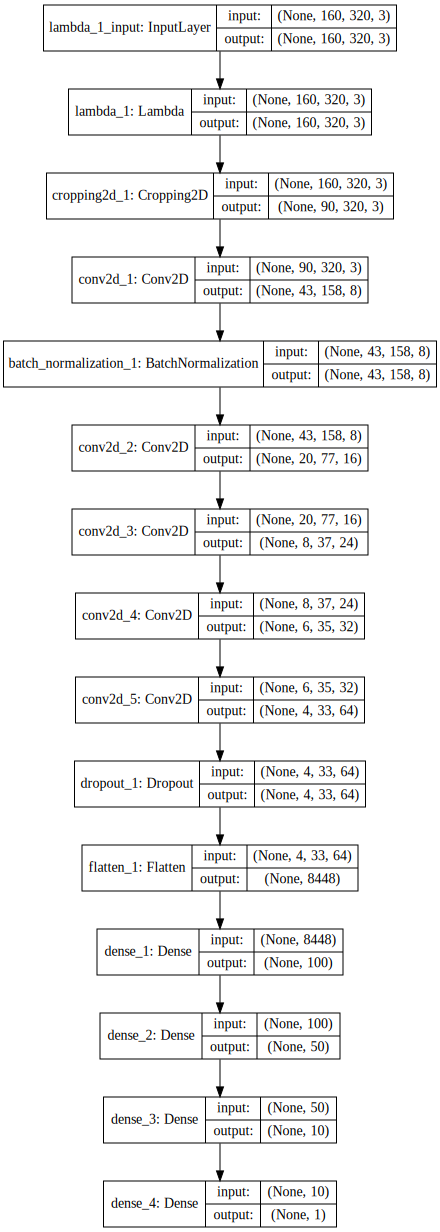

In [7]:
from IPython.display import Image, display, SVG
from keras.utils.vis_utils import model_to_dot

# Show the model in ipython notebook
figure = SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))
display(figure)

**Behavioral Cloning Project**

The goals / steps of this project are the following:
* Use the simulator to collect data of good driving behavior
* Build, a convolution neural network in Keras that predicts steering angles from images
* Train and validate the model with a training and validation set
* Test that the model successfully drives around track one without leaving the road
* Summarize the results with a written report


#### Files Submitted & Code Quality

*1. Submission includes all required files and can be used to run the simulator in autonomous mode*

My project includes the following files:
* Model.ipynb containing the script to create and train the model
* drive.py for driving the car in autonomous mode; Changed the speed to 15 from the default udacity code
* model.h5 containing a trained convolution neural network
* writeup_report.md or writeup_report.pdf summarizing the results
* test0.mp4 video of the car completing a lap 

Since the reviewer asked for a modified version using fit_generator, there is an aditional notebook Model.gen.ipynb. I did experiment with several different sizes but the approach did not yield good accuracy. The car either drives itself into the hills or drowns itself in the water with the model trained from that approach. 
test4.mp4 is the video recorded from this last model.h5. 

I am not sure why the reviewer was not able to use the model.h5 to drive the car. I have been doing the projects on a ubuntu 14 desktop and my mac for recording the video. This is because my desktop is remote and the simulator has issues with vnc. I also had several models when I tried downloading the model.h5 from aws. Tensorflow gave me an invalid opcode error. Most forums mention this happens when the versions of keras/tensorflow dont match. I verified the versions of the libraries and they do actually match. Unfortunately I have no solution for the error in trying to run the model.h5. I seem to be able to run it and I am uploading a second video from the latest model.h5 for this submission. You could try the new model.h5 that I am checking in and hopefully it will work this time. 

*2. Submission includes functional code*
Using the Udacity provided simulator and my drive.py file, the car can be driven autonomously around the track by executing
```sh
python drive.py model.h5
```

*3. Submission code is usable and readable*
The Model.ipynb file contains the code for training and saving the convolution neural network. The file shows the pipeline I used for training and validating the model, and it contains comments to explain how the code works.

#### Model Architecture and Training Strategy

*1. An appropriate model architecture has been employed*

My model is a slightly modified version of the Nvidia architecture described in class (http://images.nvidia.com/content/tegra/automotive/images/ 2016/solutions/pdf/end-to-end-dl-using-px.pdf).
Figure 4 and "section 4 Network Architecture" provided all the details for the base implementation. I expermiented with different max pooloing   and dropout  layers. Finally settled on a single additional batch normalization layer after the first Convolution layer.

I also used the cropping layer + normalization layer as described in the lectures. This is done before the convolution layers. I had great success with Batch normalization in my previous project and decided to try it here. There was a good boost in accuracy with the additional layer. The car still had trouble making two somewhat sharp turns. I then captured some of the images by running the simulator in training mode and that gave the accuracy a boost of ~10%.

Batch normalization is a common technique for improving optimization given a large data set. In the process of optimization it does some regularization, therby introducing noise and forcing the neural net to generalize. I read some literature that says both techniques could be used, but I had little success using both. The single batch norm layer was able to improve the accuracy enough for the car to stay on the track.

*2. Attempts to reduce overfitting in the model*

Experimented with dropout layers. The best accuracy was with the additional batch norm layer.

The model was trained and validated on different data sets to ensure that the model was not overfitting. The model was tested by running it through the simulator and ensuring that the vehicle could stay on the track. 

*3. Model parameter tuning*

The model used an adam optimizer, so the learning rate was not tuned manually.

*4. Appropriate training data*

I tried to generate my own images from running the simulator. The simulator did not work very well on my computer and would hang. I guess I need a more powerful machine. The fan on this laptop sounds like its on the verge of blowing up.
I eventually used the images provided. Center+left+right camera images. I flipped some randomly picked images as can be seen in the graph after  cnt 8000. I set the validation split to be 25%

#### Model Architecture and Training Strategy

*1. Solution Design Approach*
1. Try to collect training images using simulator
2. Used udacity training data
3. Crop and normalize layers using keras
4. Nvidia deep learning network model
5. Experiment with different batch norm/max pooling/drop out layers. Captured model.h5 files and moitored validation accuracy.
6. Picked the best model that runs on the simulator in auto mode

The second python notebook using the generator did not work very well. Both the reviewers suggessted using that approach and while it does use much lesser memory, I was not able to get any good accuracy. I experiemented a lot with different batch sizes/epochs. The loss did come down with several epochs but the accuracy never went beyond 35%. I am uploading the notebook to show that I tried the aproach, just did not work well.

*2. Final Model Architecture*

Described above and plotted using the mode_to_dot function of keras.

*3. Creation of the Training Set & Training Process*

Collecting my own images did not work very well. I was not able to run the simulator in aws. It would not start on my linux laptop. Eventually got it to work on my mac but it was using a lot of cpu and driving the fan nuts. I did captur some images for the turns by running the simulator in training mode and the smallest window size. I have used a small subset of them to help improve the model. My steering angle is a lot more bursty than the test data as can be seen in the plot beyond 8000 (x-axis)
~